In [ ]:
import re
from collections import Counter
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import load_dataset

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Use eos_token as pad_token to enable padding without adding new tokens to the vocab.
# This allows batching with padding=True and ensures the model ignores padding in the loss.
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

In [ ]:
# Load Wikitext-2 dataset
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
texts = ds["text"]

In [26]:
# Tokenize the text into word-like units and extract all n-grams of size n
def get_ngrams(text, n):
    toks = re.findall(r"\w+|\S", text.lower())
    return zip(*(toks[i:] for i in range(n)))

# Count frequency of all bigrams and trigrams in the dataset
bigrams = Counter()
trigrams = Counter()
for txt in texts:
    bigrams.update(" ".join(g) for g in get_ngrams(txt, 2))
    trigrams.update(" ".join(g) for g in get_ngrams(txt, 3))


In [ ]:
#HERE WE SET HOW MANY N GRAMS WE WANT
TOP_K_BIGRAMS = 100
TOP_K_TRIGRAMS = 100

# pick top-k most frequent ngrams
bigram_tokens = [g for g, _ in bigrams.most_common(TOP_K_BIGRAMS)]
trigram_tokens = [g for g, _ in trigrams.most_common(TOP_K_TRIGRAMS)]

# Print how many n-grams were selected
print(f"Selected {len(bigram_tokens)} bigrams and {len(trigram_tokens)} trigrams.")

# Map each frequent ngram to a unique pseudo-token
bigram_to_token = {phrase: f"<BI_{i}>" for i, phrase in enumerate(bigram_tokens)}
trigram_to_token = {phrase: f"<TRI_{i}>" for i, phrase in enumerate(trigram_tokens)}

# Combine all pseudo-tokens into a single list to be added to the tokenizer
new_tokens = list(bigram_to_token.values()) + list(trigram_to_token.values())

# Save the current vocabulary size to use as the index offset for n-gram tokens
bi_offset = tokenizer.vocab_size

# Add the new pseudo-tokens to the tokenizer's vocabulary
tokenizer.add_tokens(new_tokens)

# Resize the model's embedding layer to match the new vocabulary size
model.resize_token_embeddings(len(tokenizer))

# map phrases to token ids using the original tokenizer (before pseudo-tokens are used)
# This mapping is used to initialize the n-gram embeddings from the base model
bigram_token_ids = {phrase: tokenizer.encode(phrase, add_special_tokens=False)
                    for phrase in bigram_tokens}
trigram_token_ids = {phrase: tokenizer.encode(phrase, add_special_tokens=False)
                     for phrase in trigram_tokens}

# Create a unified embedding table for all bigram and trigram pseudo-tokens,
# initializing each vector as the mean of the constituent token embeddings.
all_phrases = bigram_tokens + trigram_tokens
embed_dim = model.transformer.wte.embedding_dim
ngram_embeddings = nn.Embedding(len(all_phrases), embed_dim)
with torch.no_grad():
    for i, phrase in enumerate(all_phrases):
        ids = bigram_token_ids.get(phrase) or trigram_token_ids.get(phrase)
        if ids:
            embeds = torch.stack([model.transformer.wte.weight[tid] for tid in ids])
            ngram_embeddings.weight[i] = embeds.mean(dim=0)

# Allow gradients to flow through the new ngram embeddings only
ngram_embeddings.weight.requires_grad = True

Selected 100 bigrams and 100 trigrams.


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# Custom GPT2 wrapper with n-gram support
class GPT2WithNgrams(nn.Module):
    def __init__(self, base_model, ngram_offset, ngram_embeddings):
        super().__init__()
        self.model = base_model
        self.ngram_offset = ngram_offset
        self.ngram_embed = ngram_embeddings

    def forward(self, input_ids, attention_mask=None, labels=None):
        base_embeds = self.model.transformer.wte(input_ids)
        ngram_pos = input_ids >= self.ngram_offset
        ngram_indices = (input_ids - self.ngram_offset).clamp(min=0)
        ngram_embeds = self.ngram_embed(ngram_indices)
        embeds = torch.where(
            ngram_pos.unsqueeze(-1),
            ngram_embeds,
            base_embeds
        )
        return self.model(inputs_embeds=embeds,
                          attention_mask=attention_mask,
                          labels=labels)

# instantiate extended model and move embeddings to same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ngram = GPT2WithNgrams(model, bi_offset, ngram_embeddings).to(device)

total_params = sum(p.numel() for p in model_ngram.parameters())
trainable_params = sum(p.numel() for p in model_ngram.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")



Total parameters: 124747008
Trainable parameters: 153600


In [ ]:
# Prepare data loader
combined_ngram_to_token = {**bigram_to_token, **trigram_to_token}

# This function replaces n-gram phrases in the text with their corresponding pseudo-token strings before tokenization
def preprocess(text):
    text = text.lower()
    for phrase, token in combined_ngram_to_token.items():
        text = text.replace(phrase, token)
    return text

# This function tokenizes a batch of texts after replacing n-grams, and returns tensors for model input
def encode_batch(batch_texts):
    proc = [preprocess(t) for t in batch_texts if t.strip()]
    tok = tokenizer(proc, padding=True, truncation=True, return_tensors="pt")
    return tok.input_ids.to(device), tok.attention_mask.to(device)

# HERE WE CAN CHANGE HOW MANY TEXTS WE WILL HAVE IN TRAINING
subset = ds.select(range(400))

loader = DataLoader(subset, batch_size=8, shuffle=True,
                    collate_fn=lambda b: encode_batch([d["text"] for d in b]))

# Fine tune the model of 100 2-grams and 100 3-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: avg_loss=8.4363
Epoch 2: avg_loss=8.0556
Epoch 3: avg_loss=7.6568
Epoch 4: avg_loss=7.3440
Epoch 5: avg_loss=7.2156
Epoch 6: avg_loss=6.9040
Epoch 7: avg_loss=6.7864
Epoch 8: avg_loss=6.6985
Epoch 9: avg_loss=6.4384
Epoch 10: avg_loss=6.2699
Epoch 11: avg_loss=6.3083
Epoch 12: avg_loss=6.1365
Epoch 13: avg_loss=6.0062
Epoch 14: avg_loss=6.0788
Epoch 15: avg_loss=6.0646
Epoch 16: avg_loss=5.9249
Epoch 17: avg_loss=6.0151
Epoch 18: avg_loss=5.9471
Epoch 19: avg_loss=6.0760
Epoch 20: avg_loss=6.0089


# Fine tune the model of 1000 2-grams and 1000 3-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: avg_loss=8.7129
Epoch 2: avg_loss=8.3422
Epoch 3: avg_loss=7.9007
Epoch 4: avg_loss=7.5493
Epoch 5: avg_loss=7.3144
Epoch 6: avg_loss=7.0585
Epoch 7: avg_loss=6.8443
Epoch 8: avg_loss=6.7171
Epoch 9: avg_loss=6.4223
Epoch 10: avg_loss=6.3555
Epoch 11: avg_loss=6.3060
Epoch 12: avg_loss=6.1512
Epoch 13: avg_loss=5.9943
Epoch 14: avg_loss=6.0780
Epoch 15: avg_loss=5.9219
Epoch 16: avg_loss=6.0006
Epoch 17: avg_loss=5.8116
Epoch 18: avg_loss=5.8897
Epoch 19: avg_loss=5.6060
Epoch 20: avg_loss=5.6549


# Fine tune the model of 10.000 2-grams and 10.000 3-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: avg_loss=9.0870
Epoch 2: avg_loss=8.4613
Epoch 3: avg_loss=7.8239
Epoch 4: avg_loss=7.4213
Epoch 5: avg_loss=7.1261
Epoch 6: avg_loss=6.9574
Epoch 7: avg_loss=6.7025
Epoch 8: avg_loss=6.5701
Epoch 9: avg_loss=6.3901
Epoch 10: avg_loss=6.0996
Epoch 11: avg_loss=5.9457
Epoch 12: avg_loss=5.6274
Epoch 13: avg_loss=5.6277
Epoch 14: avg_loss=5.5622
Epoch 15: avg_loss=5.3924
Epoch 16: avg_loss=5.2360
Epoch 17: avg_loss=5.1335
Epoch 18: avg_loss=5.0771
Epoch 19: avg_loss=5.0767
Epoch 20: avg_loss=5.0347


# Fine tune the model of 100.000 2-grams and 100.000 3-grams

In [ ]:
# Fine-tuning loop (only ngram embeddings)
optimizer = AdamW([{'params': ngram_embeddings.parameters()}], lr=1e-3)
model_ngram.train()
for epoch in range(20):
    total_loss = 0.0
    for input_ids, attn in loader:
        out = model_ngram(input_ids=input_ids, attention_mask=attn, labels=input_ids)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: avg_loss={total_loss/len(loader):.4f}")


Epoch 1: avg_loss=9.3197
Epoch 2: avg_loss=8.6669
Epoch 3: avg_loss=7.9201
Epoch 4: avg_loss=7.5167
Epoch 5: avg_loss=7.2564
Epoch 6: avg_loss=7.1282
Epoch 7: avg_loss=6.8079
Epoch 8: avg_loss=6.6710
Epoch 9: avg_loss=6.0612
Epoch 10: avg_loss=5.7676
Epoch 11: avg_loss=5.8955
Epoch 12: avg_loss=5.8039
Epoch 13: avg_loss=5.3279
Epoch 14: avg_loss=5.3723
Epoch 15: avg_loss=5.1245
Epoch 16: avg_loss=4.9245
Epoch 17: avg_loss=5.1344
Epoch 18: avg_loss=4.6770
Epoch 19: avg_loss=4.7849
Epoch 20: avg_loss=4.6514


In [ ]:
#torch.save(ngram_embeddings.state_dict(), "ngram_embeddings.pt")
#print("Bigram+Trigram embeddings fine-tuned and saved.")


#OE

In [ ]:
import torch.nn.functional as F

# Evaluation function for multiple-choice tasks

def score_choices(ctx, endings):
    # Combine context with each candidate ending and preprocess the result
    inputs = []
    for ending in endings:
        full = preprocess(ctx + " " + ending)
        inputs.append(full)

    # Tokenize all full candidate sequences and send to the appropriate device
    encoded = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():

        # Run the model with labels to get the loss for each token
        outputs = model_ngram(**encoded, labels=encoded["input_ids"])

        # Compute cross-entropy loss without reduction (per-token loss)
        loss = F.cross_entropy(
            outputs.logits.view(-1, outputs.logits.size(-1)),
            encoded["input_ids"].view(-1),
            ignore_index=tokenizer.pad_token_id,
            reduction='none'
        )

        # Sum loss over all tokens for each input to get total loss per candidate
        loss_per_input = loss.view(encoded["input_ids"].shape).sum(dim=1)

    # Return list of losses, one per candidate ending
    return loss_per_input.tolist()


#BASELINE

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

baseline_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
baseline_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

def score_choices_baseline(ctx, endings):
    inputs = []
    for ending in endings:
        full = ctx + " " + ending
        inputs.append(full)

    baseline_tokenizer.pad_token = baseline_tokenizer.eos_token
    baseline_model.config.pad_token_id = baseline_tokenizer.eos_token_id


    encoded = baseline_tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = baseline_model(**encoded, labels=encoded["input_ids"])
        loss = F.cross_entropy(
            outputs.logits.view(-1, outputs.logits.size(-1)),
            encoded["input_ids"].view(-1),
            ignore_index=baseline_tokenizer.pad_token_id,
            reduction='none'
        )
        loss_per_input = loss.view(encoded["input_ids"].shape).sum(dim=1)
    return loss_per_input.tolist()


#Hellaswag dataset


In [ ]:
from datasets import load_dataset

hellaswag = load_dataset("hellaswag", split="validation")



README.md:   0%|          | 0.00/6.84k [00:00<?, ?B/s]

hellaswag.py:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

#BASELINE

In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK WE WANT TO TEST AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices_baseline(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"[Baseline GPT-2] Accuracy on HellaSwag: {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


[Baseline GPT-2] Accuracy on HellaSwag: 128/500 = 25.60%


# Testing the model of 100 2-grams and 100 3-grams


In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 131/500 = 26.20%


# Testing the model of 1000 2-grams and 1000 3-grams


In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 137/500 = 27.40%


# Testing the model of 10.000 2-grams and 10.000 3-grams





In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 138/500 = 27.60%


# Testing the model of 100.000 2-grams and 100.000 3-grams


In [ ]:
correct = 0
total = 0

for example in hellaswag.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["ctx"]
    choices = example["endings"]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on HellaSwag (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on HellaSwag (subset): 144/500 = 28.80%


#PIQA DATASET

In [ ]:
from datasets import load_dataset

piqa = load_dataset("piqa", split="validation")



README.md:   0%|          | 0.00/8.41k [00:00<?, ?B/s]

piqa.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

The repository for piqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/piqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

#BASELINE

In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK WE WANT TO TEST AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices_baseline(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"[Baseline GPT-2] Accuracy on PIQA: {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


[Baseline GPT-2] Accuracy on PIQA: 272/500 = 54.40%


# Testing the model of 100 2-grams and 100 3-grams





In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 259/500 = 51.80%


# Testing the model of 1.000 2-grams and 1.000 3-grams


In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 246/500 = 49.20%


# Testing the model of 10.000 2-grams and 10.000 3-grams


In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 257/500 = 51.40%


# Testing the model of 100.000 2-grams and 100.000 3-grams


In [ ]:
correct = 0
total = 0

for example in piqa.select(range(500)):  #HERE WE CAN CHANGE THE DOWNSTREAN TASK AND THE SAMPLES
    ctx = example["goal"]
    choices = [example["sol1"], example["sol2"]]
    gold = int(example["label"])

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on PIQA (subset): {correct}/{total} = {correct / total:.2%}") #WE CAN CHANGE THE NAME OF THE TASK


Accuracy on PIQA (subset): 253/500 = 50.60%


#Story Cloze DATASET

In [ ]:
from datasets import load_dataset

from google.colab import drive
drive.mount('/content/drive')


from datasets import load_dataset

val_path = "/content/drive/MyDrive/Colab Notebooks/cloze_test_val__winter2018-cloze_test_ALL_val - 1 - 1.csv"
story_cloze = load_dataset("csv", data_files={"validation": val_path})





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#BASELINE

In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices_baseline(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 246/500 = 49.20%


# Testing the model of 100 2-grams and 100 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 253/500 = 50.60%


# Testing the model of 1.000 2-grams and 1.000 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 257/500 = 51.40%


# Testing the model of 10.000 2-grams and 10.000 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 258/500 = 51.60%


# Testing the model of 100.000 2-grams and 100.000 3-grams


In [ ]:
correct = 0
total = 0

for example in story_cloze["validation"].select(range(500)):
    ctx = " ".join([example[f"InputSentence{i}"] for i in range(1, 5)])
    choices = [example["RandomFifthSentenceQuiz1"], example["RandomFifthSentenceQuiz2"]]
    gold = 0

    losses = score_choices(ctx, choices)
    pred = losses.index(min(losses))

    if pred == gold:
        correct += 1
    total += 1

print(f"Accuracy on Story Cloze 2018 (validation): {correct}/{total} = {correct / total:.2%}")

Accuracy on Story Cloze 2018 (validation): 282/500 = 56.40%


# Plotting the results

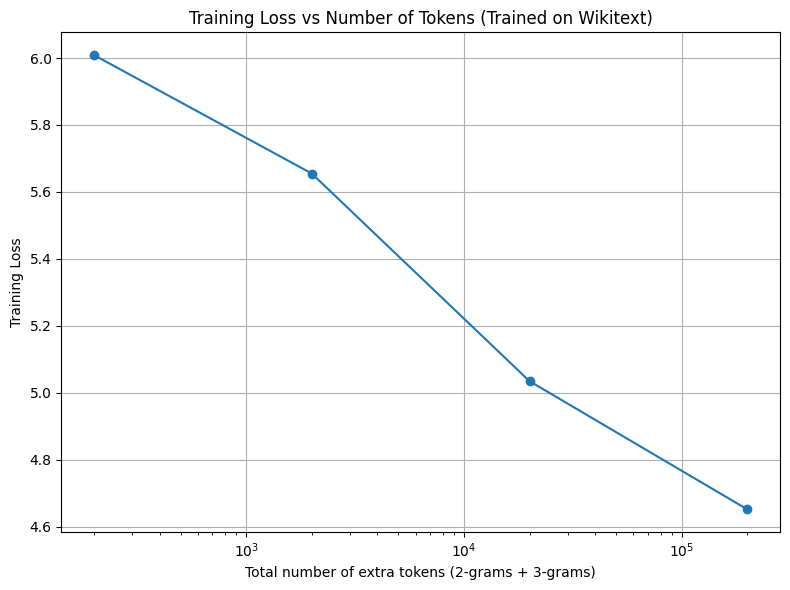

In [41]:
import matplotlib.pyplot as plt

# Data: total tokens (2-grams + 3-grams) and corresponding training loss
tokens = [200, 2000, 20000, 200000]
loss = [6.0089, 5.6549, 5.0345, 4.6514]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(tokens, loss, marker='o')
plt.xscale('log')  # Use logarithmic scale for better visualization of token growth
plt.xlabel('Total number of extra tokens (2-grams + 3-grams)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Number of Tokens (Trained on Wikitext)')
plt.grid(True)
plt.tight_layout()
plt.show()


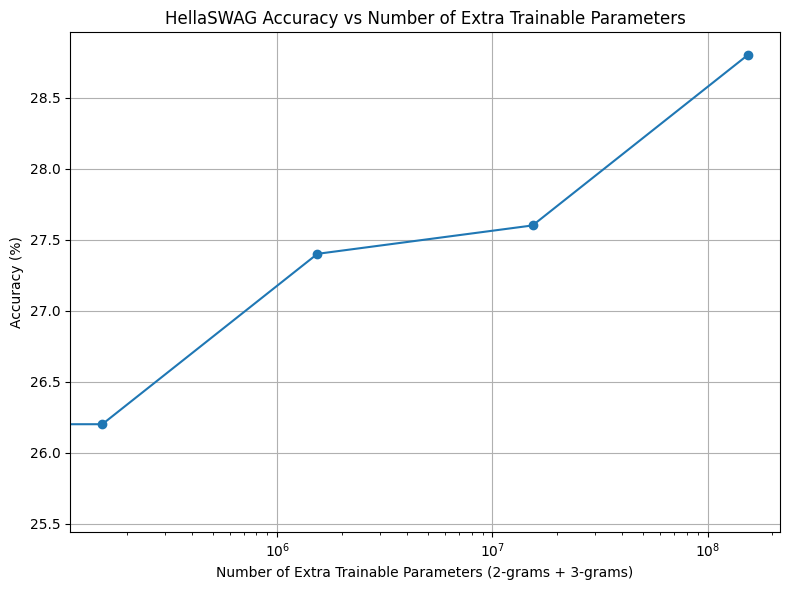

In [36]:
import matplotlib.pyplot as plt

# Data: number of extra tokens and corresponding accuracy on HellaSWAG
extra_params = [0, 153600, 1536000, 15360000, 153600000]
accuracy = [25.6, 26.2, 27.4, 27.6, 28.8]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(extra_params, accuracy, marker='o')
plt.xscale('log')  # Log scale to visualize the growth
plt.xlabel('Number of Extra Trainable Parameters (2-grams + 3-grams)')
plt.ylabel('Accuracy (%)')
plt.title('HellaSWAG Accuracy vs Number of Extra Trainable Parameters')
plt.grid(True)
plt.tight_layout()
plt.show()


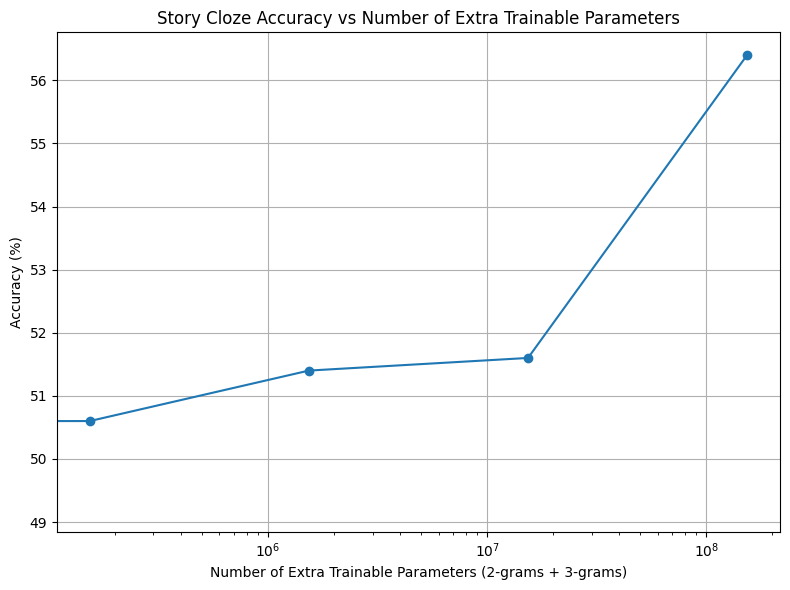

In [38]:
extra_params = [0, 153600, 1536000, 15360000, 153600000]
accuracy = [49.2, 50.6, 51.4, 51.6, 56.4]

plt.figure(figsize=(8, 6))
plt.plot(extra_params, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (2-grams + 3-grams)')
plt.ylabel('Accuracy (%)')
plt.title('Story Cloze Accuracy vs Number of Extra Trainable Parameters')
plt.grid(True)
plt.tight_layout()
plt.show()


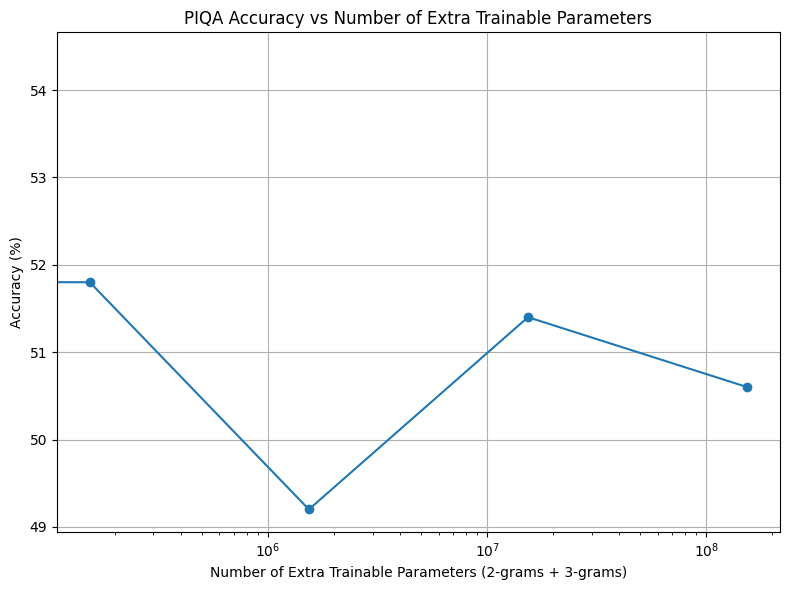

In [39]:
extra_params = [0, 153600, 1536000, 15360000, 153600000]
accuracy = [54.4, 51.8, 49.2, 51.4, 50.6]

plt.figure(figsize=(8, 6))
plt.plot(extra_params, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (2-grams + 3-grams)')
plt.ylabel('Accuracy (%)')
plt.title('PIQA Accuracy vs Number of Extra Trainable Parameters')
plt.grid(True)
plt.tight_layout()
plt.show()


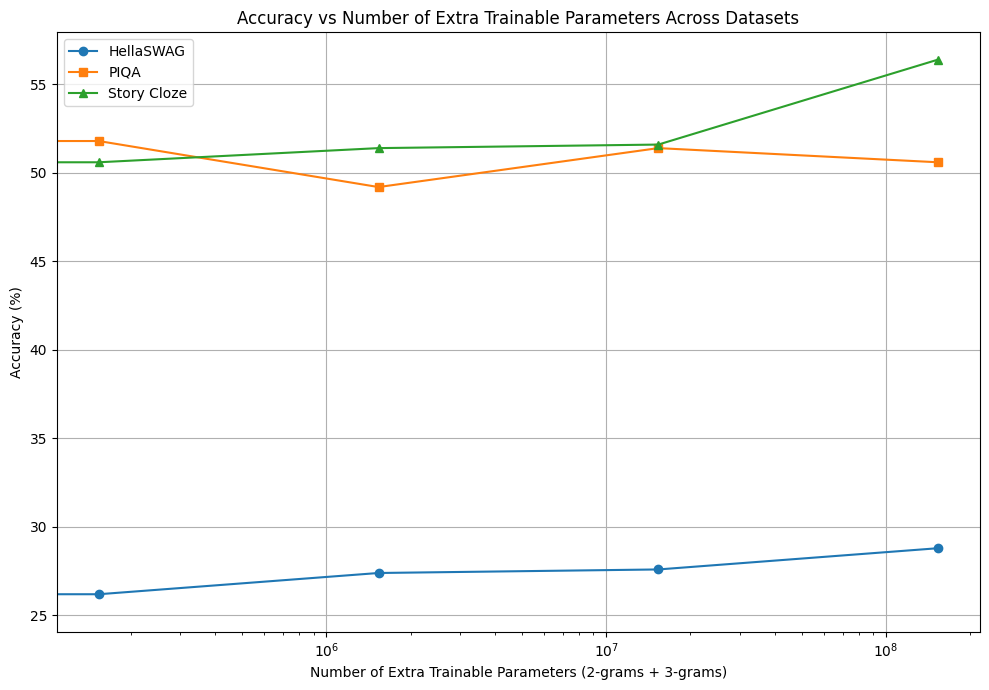

In [40]:
extra_params = [0, 153600, 1536000, 15360000, 153600000]

hellaswag = [25.6, 26.2, 27.4, 27.6, 28.8]
piqa = [54.4, 51.8, 49.2, 51.4, 50.6]
story_cloze = [49.2, 50.6, 51.4, 51.6, 56.4]

plt.figure(figsize=(10, 7))
plt.plot(extra_params, hellaswag, marker='o', label='HellaSWAG')
plt.plot(extra_params, piqa, marker='s', label='PIQA')
plt.plot(extra_params, story_cloze, marker='^', label='Story Cloze')

plt.xscale('log')
plt.xlabel('Number of Extra Trainable Parameters (2-grams + 3-grams)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Extra Trainable Parameters Across Datasets')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
